In [11]:
!pip3 install gymnasium[box2d]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Shaunak Kolhe \
133008312 \
ECEN 743 ASSIGNMENT 4 \
DUELING DEEP Q LEARNING \




In [12]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym, time
import matplotlib.pyplot as plt


# For visualization
from collections import deque, namedtuple
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import base64, io
import glob
import cv2

In [13]:

class ExperienceReplay(object):
  """ 
  Based on the Replay Buffer implementation of TD3 
  Reference: https://github.com/sfujim/TD3/blob/master/utils.py
  """
  def __init__(self, max_size, input_shape, n_actions):
      self.memory_size = max_size
      self.memory_count = 0
      self.state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
      self.next_state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
      self.action_memory = np.zeros(self.memory_size, dtype=np.int64)
      self.reward_memory = np.zeros(self.memory_size, dtype=np.float32)
      self.terminal_memory = np.zeros(self.memory_size, dtype=np.uint8)

  def add(self, state, action, reward, next_state, done):
      ptr = self.memory_count % self.memory_size
      self.state_memory[ptr] = state
      self.next_state_memory[ptr] = next_state
      self.action_memory[ptr] = action
      self.reward_memory[ptr] = reward
      self.terminal_memory[ptr] = done
      self.memory_count = self.memory_count + 1

  def sample(self, batch_size):
      max_mem = min(self.memory_count, self.memory_size)
      batch = np.random.choice(max_mem, batch_size, replace=False)

      states = self.state_memory[batch]
      actions = self.action_memory[batch]
      rewards = self.reward_memory[batch]
      next_states = self.next_state_memory[batch]
      terminal = self.terminal_memory[batch]

      return states, actions, rewards, next_states, terminal


class QNetwork(nn.Module):
  def __init__(self, ALPHA, n_actions, name, input_dims, chkpt_dir='tmp/dqn'):
      super(QNetwork, self).__init__()

      # Layers
      self.layer_1 = nn.Linear(*input_dims, 64)
      self.layer_2 = nn.Linear(64, 64)

      # Defining Value and Advantage layers
      self.V = nn.Linear(64, 1)
      self.A = nn.Linear(64, n_actions)

      self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)
      self.loss = nn.MSELoss()
      self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
      self.to(self.device)
      

  def forward(self, state):
      l1 = F.relu(self.layer_1(state))
      l2 = F.relu(self.layer_2(l1))
      V = self.V(l2)
      A = self.A(l2)

      return V, A

class DQNAgent(object):
  def __init__(self, discount, epsilon, alpha, n_actions, input_dims,
                memory_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                replace=1000, chkpt_dir='tmp/dqn'):
      self.discount = discount
      self.epsilon = epsilon
      self.eps_min = eps_min
      self.eps_dec = eps_dec
      self.action_space = [i for i in range(n_actions)]
      self.learn_step_counter = 0
      self.batch_size = batch_size
      self.replace_target_cnt = replace
      self.memory = ExperienceReplay(memory_size, input_dims, n_actions)

      self.q_eval = QNetwork(alpha, n_actions, input_dims=input_dims,
                                  name='q_eval', chkpt_dir=chkpt_dir)
      self.q_next = QNetwork(alpha, n_actions, input_dims=input_dims,
                                  name='q_next', chkpt_dir=chkpt_dir)

  def add(self, state, action, reward, next_state, done):
      self.memory.add(state, action, reward, next_state, done)

  def select_action(self, observation):
      if np.random.random() > self.epsilon:
          observation = observation[np.newaxis,:]
          state = T.tensor(observation).to(self.q_eval.device)
          _ , advantage = self.q_eval.forward(state)
          action = T.argmax(advantage).item()
      else:
          action = np.random.choice(self.action_space)

      return action

  def replace_target_network(self):
      if self.replace_target_cnt is not None and \
          self.learn_step_counter % self.replace_target_cnt == 0:
          self.q_next.load_state_dict(self.q_eval.state_dict())

  def decrement_epsilon(self):
      self.epsilon = self.epsilon - self.eps_dec \
                        if self.epsilon > self.eps_min else self.eps_min

  def learn(self):
      if self.memory.memory_count < self.batch_size:
          return

      self.q_eval.optimizer.zero_grad()
      self.replace_target_network()
      state, action, reward, new_state, done = \
                              self.memory.sample(self.batch_size)


      # Running experiences through device
      state = T.tensor(state).to(self.q_eval.device)
      new_state = T.tensor(new_state).to(self.q_eval.device)
      action = T.tensor(action).to(self.q_eval.device)
      rewards = T.tensor(reward).to(self.q_eval.device)
      dones = T.tensor(done).to(self.q_eval.device)

      # Values and advantages for states
      V_state, A_state = self.q_eval.forward(state)
      V_next_state, A_next_state = self.q_next.forward(new_state)

      q_pred = T.add(V_state, (A_state - A_state.mean(dim=1, keepdim=True))).gather(1,
                                            action.unsqueeze(-1)).squeeze(-1)

      # Evaluating Q_next 
      q_next = T.add(V_next_state, (A_next_state - A_next_state.mean(dim=1, keepdim=True)))
      q_target = rewards + self.discount*T.max(q_next, dim=1)[0].detach()
      q_target[dones] = 0.0

      # Calculating loss and backpropogating
      loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
      loss.backward()
      self.q_eval.optimizer.step()
      self.learn_step_counter = self.learn_step_counter + 1
      self.decrement_epsilon()
#_______________________________________________________________________________________________


<ipython-input-13-0a9ad7812ba6>:132: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  q_target[dones] = 0.0


episode:  0 score -419.4   average score -419.4 epsilon 0.96
episode:  1 score -118.9   average score -269.1 epsilon 0.87
episode:  2 score -115.8   average score -218.0 epsilon 0.81
episode:  3 score -150.6   average score -201.1 epsilon 0.72
episode:  4 score -405.8   average score -242.1 epsilon 0.61
episode:  5 score -134.5   average score -224.1 epsilon 0.51
episode:  6 score -275.4   average score -231.5 epsilon 0.23
episode:  7 score -125.0   average score -218.2 epsilon 0.01
episode:  8 score -349.3   average score -232.7 epsilon 0.01
episode:  9 score -487.0   average score -258.2 epsilon 0.01
episode:  10 score -265.7   average score -258.8 epsilon 0.01
episode:  11 score -176.5   average score -252.0 epsilon 0.01
episode:  12 score 14.2   average score -231.5 epsilon 0.01
episode:  13 score -5.9   average score -215.4 epsilon 0.01
episode:  14 score 23.3   average score -199.5 epsilon 0.01
episode:  15 score -214.3   average score -200.4 epsilon 0.01
episode:  16 score -176.

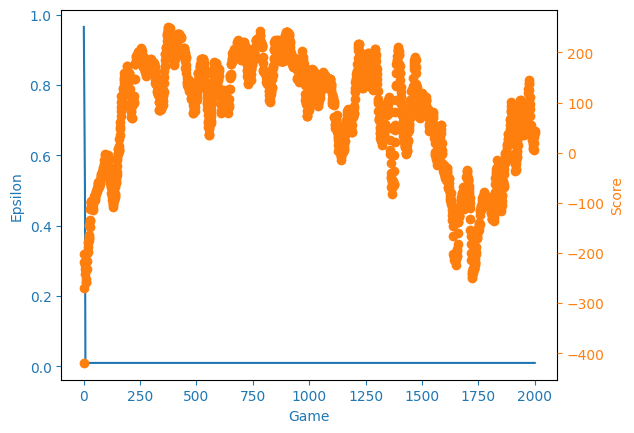

In [14]:
# Plotting Function
def plotting(x, scores, epsilons, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)
    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")
#_____________________________________________________________________________
# Main Function

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    num_games = 2000
    agent = DQNAgent(discount=0.99, epsilon=1.0, alpha=5e-4,
                  input_dims=[8], n_actions=4, memory_size=10000, eps_min=0.01,
                  batch_size=64, eps_dec=1e-3, replace=100)

    scores = []
    eps_history = []
    n_steps = 0
    moving_window = deque(maxlen=100)

    for i in range(num_games):
        done = False
        observation = env.reset()
        score = 0

        while not done:
            action = agent.select_action(observation)
            next_observation, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.add(observation, action,
                                    reward, next_observation, int(done))
            agent.learn()

            observation = next_observation


        scores.append(score)
        moving_window.append(score)

        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score %.1f ' % score,
             ' average score %.1f' % avg_score,
            'epsilon %.2f' % agent.epsilon)

        eps_history.append(agent.epsilon)

    x = [i+1 for i in range(num_games)]
    plotting(x, scores, eps_history)